📊 Dane:
  X_train: (70043, 320)
  y_train: (70043, 1500)
  X_val: (12361, 320)
  y_val: (12361, 1500)
🖥️ Device: cuda

🏋️ Trenowanie sieci...

Epoch  1 | Train Loss: 0.0921 | Val Loss: 0.0808 | LR: 0.001000
Epoch  2 | Train Loss: 0.0789 | Val Loss: 0.0790 | LR: 0.001000
Epoch  3 | Train Loss: 0.0773 | Val Loss: 0.0767 | LR: 0.001000
Epoch  4 | Train Loss: 0.0762 | Val Loss: 0.0765 | LR: 0.001000
Epoch  5 | Train Loss: 0.0754 | Val Loss: 0.0758 | LR: 0.001000
Epoch  6 | Train Loss: 0.0748 | Val Loss: 0.0756 | LR: 0.001000
Epoch  7 | Train Loss: 0.0742 | Val Loss: 0.0749 | LR: 0.001000
Epoch  8 | Train Loss: 0.0737 | Val Loss: 0.0753 | LR: 0.001000
Epoch  9 | Train Loss: 0.0732 | Val Loss: 0.0743 | LR: 0.001000
Epoch 10 | Train Loss: 0.0728 | Val Loss: 0.0742 | LR: 0.001000
Epoch 11 | Train Loss: 0.0723 | Val Loss: 0.0738 | LR: 0.001000
Epoch 12 | Train Loss: 0.0720 | Val Loss: 0.0739 | LR: 0.001000
Epoch 13 | Train Loss: 0.0716 | Val Loss: 0.0740 | LR: 0.001000
Epoch 14 | Train Loss: 0.

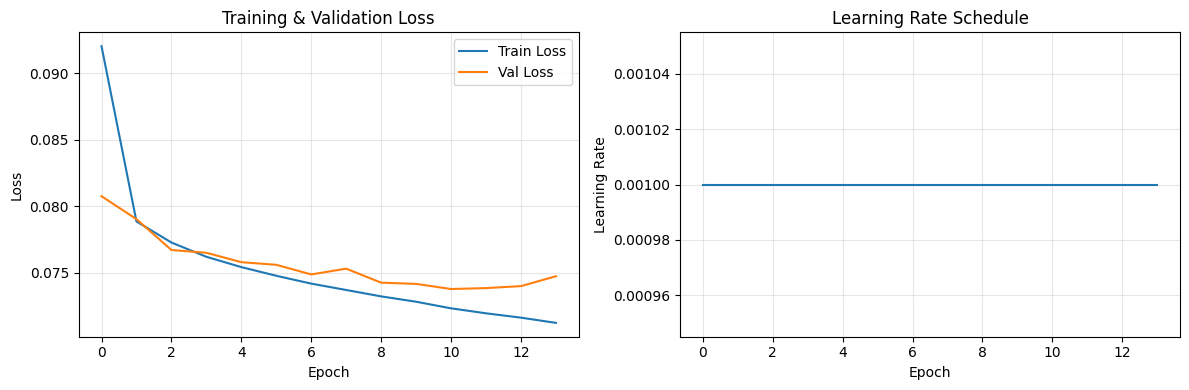

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


# 🆕 DODAJ: Wczytaj osobno train i val
X_train = np.load("../data/gold/X_train_esm2.npy")
X_val = np.load("../data/gold/X_train_esm2.npy")  # To trzeba będzie rozdzielić
y_train = np.load("../data/gold/y_train_labels.npy")
y_val = np.load("../data/gold/y_val_labels.npy")

# 🆕 DODAJ: Mapowanie IDs do embeddingów
train_ids_labels = np.load("../data/gold/train_protein_ids.npy", allow_pickle=True)
val_ids_labels = np.load("../data/gold/val_protein_ids.npy", allow_pickle=True)
all_ids_emb = np.load("../data/gold/train_ids.npy", allow_pickle=True)

# Znajdź indeksy
train_idx_emb = [np.where(all_ids_emb == pid)[0][0] for pid in train_ids_labels]
val_idx_emb = [np.where(all_ids_emb == pid)[0][0] for pid in val_ids_labels]

X_train = X_train[train_idx_emb]
X_val = X_val[val_idx_emb]

print(f"📊 Dane:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Device: {device}")

# DataLoaders
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Model
class ProteinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(320, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1024, 1500)
        )
    def forward(self, x): 
        return self.net(x)

model = ProteinClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🆕 DODAJ: Learning rate scheduler


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# 🆕 DODAJ: Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# 🆕 DODAJ: Historia treningowa
history = {'train_loss': [], 'val_loss': [], 'lr': []}

print("\n🏋️ Trenowanie sieci...\n")

for epoch in range(50):  # 🆕 ZMIEŃ: Zwiększ do 50 (early stopping zatrzyma wcześniej)
    # === TRAINING ===
    model.train()
    train_loss = 0
    
    for bx, by in train_loader:
        bx, by = bx.to(device), by.to(device)
        optimizer.zero_grad()
        loss = criterion(model(bx), by)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # === VALIDATION ===
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            loss = criterion(model(bx), by)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Print
    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"\n⏹️ Early stopping at epoch {epoch+1}")
        model.load_state_dict(early_stopping.best_model)
        break

# 🆕 DODAJ: Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150)
print("\n📊 Wykresy zapisane: ../models/training_history.png")

# Save model
torch.save(model.state_dict(), "../models/protein_nn.pth")
print("💾 Model zapisany: ../models/protein_nn.pth")

# 🆕 DODAJ: Validation metrics
print("\n🎯 Obliczanie metryk na validation set...")
model.eval()
with torch.no_grad():
    y_val_pred = torch.sigmoid(model(torch.FloatTensor(X_val).to(device))).cpu().numpy()

# Test różne thresholdy
thresholds = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]
best_threshold = 0.05
best_f1 = 0

print("\n🔍 Testowanie thresholdów na validation:")
for t in thresholds:
    y_pred_binary = (y_val_pred > t).astype(int)
    f1 = f1_score(y_val, y_pred_binary, average='samples', zero_division=0)
    print(f"  Threshold {t:.2f}: F1 = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n✅ Best threshold: {best_threshold} (F1 = {best_f1:.4f})")

# Save best threshold
import json
with open('../models/best_threshold.json', 'w') as f:
    json.dump({'threshold': best_threshold, 'val_f1': best_f1}, f)

# Generowanie predykcji dla testu
print("\n🧪 Generowanie predykcji dla test set...")
X_test = np.load("../data/gold/X_test_esm2.npy")

model.eval()
with torch.no_grad():
    y_pred_nn = torch.sigmoid(model(torch.FloatTensor(X_test).to(device))).cpu().numpy()

np.save("../data/gold/y_pred_nn.npy", y_pred_nn)

print("\n✅ GOTOWE!")
print(f"  Best Val F1: {best_f1:.4f}")
print(f"  Best Threshold: {best_threshold}")
print(f"  Test predictions: {y_pred_nn.shape}")